# Train a text classifier from a pretrained model

## Setup

In [ ]:
!pip install fastai2

from fastai2.text.all import *
from pathlib import Path
import urllib.request

     |████████████████████████████████| 184kB 4.9MB/s 


## Text

In [ ]:
path = untar_data(URLs.IMDB)
path.ls()

(#7) [Path('/root/.fastai/data/imdb/README'),Path('/root/.fastai/data/imdb/train'),Path('/root/.fastai/data/imdb/tmp_clas'),Path('/root/.fastai/data/imdb/tmp_lm'),Path('/root/.fastai/data/imdb/imdb.vocab'),Path('/root/.fastai/data/imdb/unsup'),Path('/root/.fastai/data/imdb/test')]

In [ ]:
(path/'train').ls()

(#4) [Path('/root/.fastai/data/imdb/train/unsupBow.feat'),Path('/root/.fastai/data/imdb/train/pos'),Path('/root/.fastai/data/imdb/train/neg'),Path('/root/.fastai/data/imdb/train/labeledBow.feat')]

In [ ]:
dls = TextDataLoaders.from_folder(path, valid='test')

## Model Fine-Tuning

In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [ ]:
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.602154,0.382897,0.830280,02:17


epoch,train_loss,valid_loss,accuracy,time
0,0.324317,0.275881,0.881200,04:13
1,0.238823,0.224353,0.912080,04:12
2,0.183822,0.193639,0.927000,04:20
3,0.172296,0.188671,0.928280,04:20


## Predicion

In [ ]:
learn.predict("I really liked that movie!")

('pos', tensor(1), tensor([0.0021, 0.9979]))

In [ ]:
learn.predict("OMG! That was horrible!")

('neg', tensor(0), tensor([0.8895, 0.1105]))

In [ ]:
# but
learn.predict("The best movie I have seen? No, definitely not.")

('pos', tensor(1), tensor([0.0057, 0.9943]))

# Train a classifier on genomic sequences

## Data

In [ ]:
#intergenomic = pd.read_csv("https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/ECCB2020/master/data/intergenomic_seqs_50k.csv")
transcripts = pd.read_csv("https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/ECCB2020/master/data/random_transcripts.csv")

intergenomic = intergenomic[:10000]   # take only the first 10000
transcripts = transcripts[:10000]

# chr1 is used for validation
intergenomic_train = intergenomic[intergenomic.chr!="1"]
intergenomic_valid = intergenomic[intergenomic.chr=="1"]
transcripts_train = transcripts[transcripts.chr!="1"]
transcripts_valid = transcripts[transcripts.chr=="1"]

In [ ]:
# splitting the file into training and test part

!rm -rf split_tok
!rm -rf split

Path("split/train/intergenomic/").mkdir(parents=True)
Path("split/valid/intergenomic/").mkdir(parents=True)
Path("split/train/transcripts/").mkdir(parents=True)
Path("split/valid/transcripts/").mkdir(parents=True)

for i, s in enumerate(intergenomic_train.seq):
  open("split/train/intergenomic/seq"+str(i)+".txt", 'w').writelines([s])
for i, s in enumerate(intergenomic_valid.seq):
  open("split/valid/intergenomic/seq"+str(i)+".txt", 'w').writelines([s])
for i, s in enumerate(transcripts_train.seq):
  open("split/train/transcripts/seq"+str(i)+".txt", 'w').writelines([s])
for i, s in enumerate(transcripts_valid.seq):
  open("split/valid/transcripts/seq"+str(i)+".txt", 'w').writelines([s])

## Tokenizer

In [ ]:
!wget https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/ECCB2020/master/notebooks/genomic_tokenizer2.py
from genomic_tokenizer2 import tkn2

--2020-08-31 07:26:40--  https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/ECCB2020/master/notebooks/genomic_tokenizer2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 565 [text/plain]
Saving to: ‘genomic_tokenizer2.py’

genomic_tokenizer2. 100%[===================>]     565  --.-KB/s    in 0s      

2020-08-31 07:26:40 (30.5 MB/s) - ‘genomic_tokenizer2.py’ saved [565/565]



In [ ]:
tkn2("CGGCTAGC")

(#8) ['C','G','G','C','T','A','G','C']

## Data Loaders

In [ ]:
dls = TextDataLoaders.from_folder(Path("./split"), bs=128, seed=42,  
                                   tok_tfm=tkn2, seq_len=50)

In [ ]:
dls.show_batch()

,text,category
0,G T G A T T C T C T T C T T G T C T T T T A A A A A T A G T A G A T A G C T C A C T T A G C T G C C T A T A C A G A A A T G A T A A T A C C T C A G A T T T T C T C A C T A T T T T T C T A T A C A A G C T C A T C A A A C A A C A A T T G A A C A A A G G C C T T G A G G T G C C C A G A A A G C C G A A,intergenomic
1,T G C C C T T G T A A T T G T C T T C T C A T T T G T A A G G A C A C A T C T C G G C G A A T A G G A T G C C C A A G A C C C A A C T G T A G A C G G A T A A T T A A C C T T G G C C C A G T A A T G C T T A T T T C T G A A G A A C A A C C A G C T C A G C C T G C A T T G C C A A T C C A A C C A G A A,transcripts
2,C A G C C T C C A A A T C C T G G G C T C C A A G C G A T C C T C C C A C C T C A G C T T T C C G A G T A G C T G G G A C T A C A C A G G C G C C T G C C A C C C T G C T C T G C T A A T T T T T A A T T T T T T T G G G T A G A G A T G G G G G T G A G G G A G A T A G G A G T C G G G G G G G A T G C T,intergenomic
3,G T G C T A C C A A G A G A C C C C T G G A C C A A G G G A G G C T C T T A C T C G A C T C C A G G A A C T T T G C T A C C A G T G G T T G A G G C C A C A T G T G A G C A C A A A G G A G C A G A T T T T G G A T C T G C T G G T G C T G G A G C A G T T T C T A T C C A T T C T G C C C A A G G A G C T,transcripts
4,G T G G G A G C T T T G C T T G A G C C C A G G A G T T C A A G A C C A G C C T G G G C A A C A T G G T G A A A C C C T G T C T C T A T A A A A T A T A C A A A A G T T A G C C A G G T G T G G T G G C A C A C G C C T G T A G T C C C A C C T A C T C G G G A G G T T G A G T T G A G A G G A T C A C C T,intergenomic
5,T T T T A A A T G C A A T A C A T T A T T T A T A T A A T T T C T T G C A G T A A T A A T C T G T T C A G G A G A C A T T T T T T A G T C T C T A T C A A A C C A A G C A C A C A T T A T C T G C C T T G T A C T C T T G T A G A T A T T C A G T T A A A A T A C A T C C T A A T G T T T A A A G T G T T C,intergenomic
6,A A G G C A G A G C A A T G A C C A A A A C A A T C T T A A T C T T A C T A C A G C T T C C A T T C C A G C A A G G A A A A C T G A G A A T A A A C A G C A A A T G C A T A T G T A A T A T C A C A T G G A G A A A G A T G C T C T G G A G A A A A A A A G A A A G T A T T A T A A A G T G A T A G T C A A,intergenomic
7,A G T G C A G G T G T A T G C A A T G C A C T A C A A T G T T T A T A T C A C T T A A A A T A T T T G T G A C A C A T T C C A T T T G A T C T T C A G A T A A A A T A A T A A G T T A T A A G T G G T T T A G A G G T A G T C A T C T G T C T A A A A A A A A T C T A T A C A A T A T T A T A T C T T G G G,intergenomic
8,A C A T T C A C T A A A G T C C C T G G A T C T G G T C A C C A T G A A A A A G C T G G A C A G T A A G G T G A A C A T C A T T C C A A T A A T T G C A A A A G C T G A C A C C A T T G C C A A G A A T G A A C T G C A C A A A T T C A A G A G T A A G A T C A T G A G T G A A C T G G T C A G C A A T G G,transcripts


## Model Training

In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy, pretrained=False)

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.0006918309954926372)

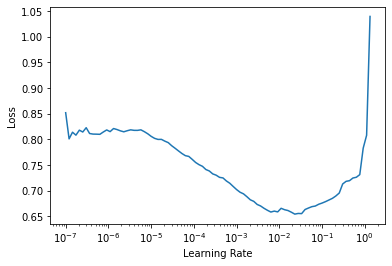

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.477583,0.563918,0.697898,01:14
1,0.413866,0.368638,0.831832,01:14
2,0.357904,0.327108,0.860060,01:14


## Testing the prediction

In [ ]:
learn.predict("AAAAAAATTAAAAAAATTAAAAAAAAAATTAAAAAAAAA")

('intergenomic', tensor(0), tensor([1.0000e+00, 1.6818e-07]))

In [ ]:
learn.predict("GACTGGAAGTTTCCTGAGGTCTCCCAGCCATGCAGAACT")

('transcripts', tensor(1), tensor([0.0449, 0.9551]))